In [ ]:
# First would be to install lightweight_mmm
!pip install --upgrade git+https://github.com/google/lightweight_mmm.git
!pip uninstall -y matplotlib
!pip install matplotlib==3.1.3

In [ ]:
# Import jax.numpy and any other library we might need.
import jax.numpy as jnp
import numpyro
import pandas as pd

In [ ]:
# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

## Organising the data for modelling

In [ ]:
from google.colab import files
df = files.upload()

In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['bike_sales_data.csv']))
# Dataset is now stored in a Pandas Dataframe

In [ ]:
df.head()

,Week,sales,branded_search_spend,nonbranded_search_spend,facebook_spend,print_spend,ooh_spend,tv_spend,radio_spend
0,7/23/17,58850.0,1528.8,463.32,802.620,0,0,0,0
1,7/30/17,62050.0,1575.6,468.00,819.312,0,0,0,0
2,8/6/17,59388.0,1544.4,477.36,749.034,0,0,0,0
3,8/13/17,56964.0,1528.8,468.00,741.468,0,0,0,0
4,8/20/17,53460.0,1560.0,458.64,811.200,0,0,0,0


In [ ]:
media_data = df[['branded_search_spend',
                 'nonbranded_search_spend',
                 'facebook_spend',
                 'print_spend',
                 'ooh_spend',
                 'tv_spend',
                 'radio_spend']].to_numpy()
target = df[['sales']].to_numpy()
costs = df[['branded_search_spend',
            'nonbranded_search_spend',
            'facebook_spend',
            'print_spend',
            'ooh_spend',
            'tv_spend',
            'radio_spend']].sum().to_numpy()

In [ ]:
media_data.shape

(260, 7)

In [ ]:
data_size = media_data.shape[0]

In [ ]:
# Split and scale data.
split_point = data_size - 30
# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]
# Target
target_train = target[:split_point].reshape(-1)

In [ ]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_train = media_scaler.fit_transform(media_data_train)
target_train = target_scaler.fit_transform(target_train)
costs2 = cost_scaler.fit_transform(costs)

In [ ]:
mmm = lightweight_mmm.LightweightMMM(model_name="carryover")

In [ ]:
number_warmup=100
number_samples=100

In [ ]:
mmm.fit(
    media=media_data_train,
    media_prior=costs2,
    target=target_train,
    number_warmup=number_warmup,
    number_samples=number_samples,
    number_chains=1,
    )

sample: 100%|██████████| 200/200 [01:17<00:00,  2.57it/s, 1023 steps of size 4.98e-03. acc. prob=0.79]


In [ ]:
mmm.print_summary()


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.71      0.30      0.87      0.17      0.99      3.70      1.58
ad_effect_retention_rate[1]      0.44      0.29      0.47      0.01      0.78     11.14      1.00
ad_effect_retention_rate[2]      0.26      0.13      0.23      0.09      0.41      9.09      1.01
ad_effect_retention_rate[3]      0.59      0.20      0.62      0.30      0.94     13.12      1.00
ad_effect_retention_rate[4]      0.48      0.21      0.45      0.23      0.87     18.66      1.10
ad_effect_retention_rate[5]      0.29      0.16      0.26      0.03      0.55      6.43      1.68
ad_effect_retention_rate[6]      0.29      0.19      0.24      0.03      0.58     26.19      1.21
              coef_media[0]      0.09      0.06      0.09      0.00      0.15     30.42      1.02
              coef_media[1]      0.21      0.05      0.21      0.12      0.29     47.93      0.99
              coef_

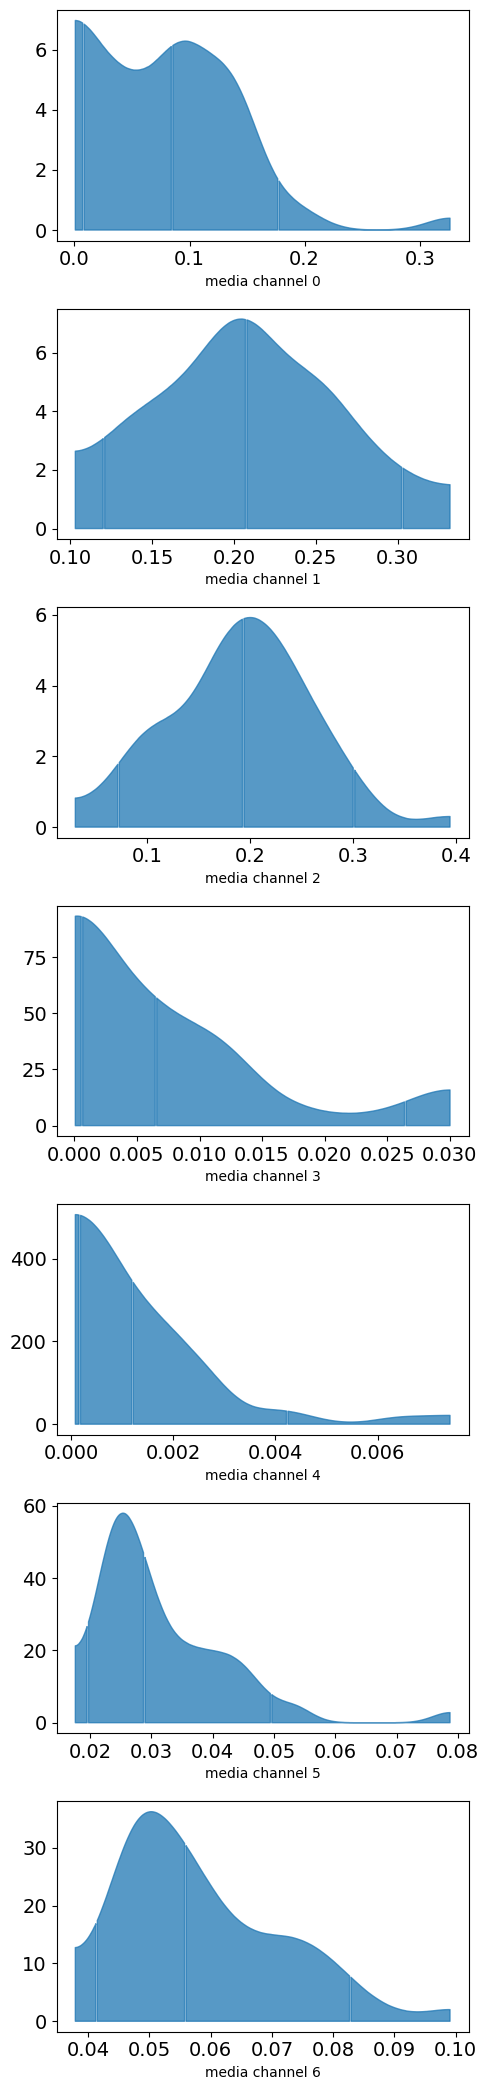

In [ ]:
plot.plot_media_channel_posteriors(media_mix_model=mmm)

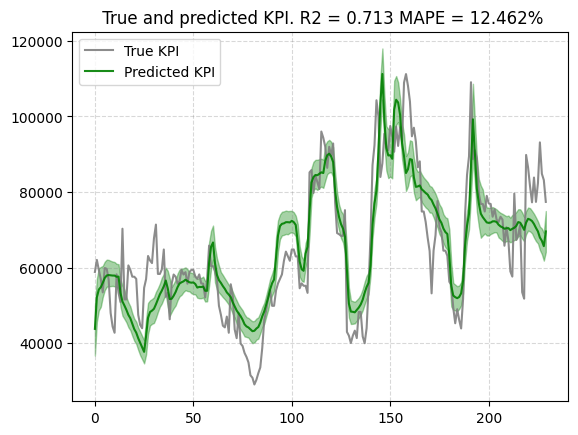

In [ ]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

In [ ]:
# We have to scale the test media data if we have not done so before.
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test))
new_predictions.shape

(100, 30)

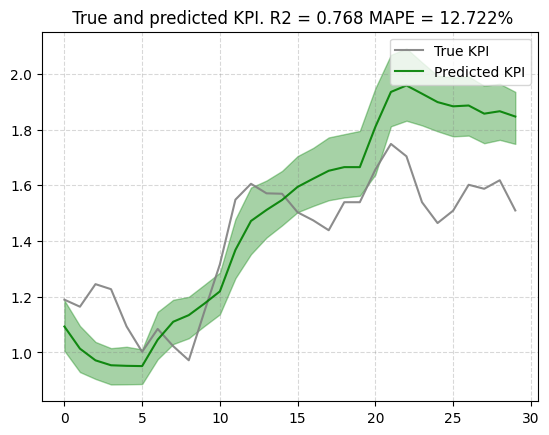

In [ ]:
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target_scaler.transform(target[split_point:].squeeze()))

### Media insights

In [ ]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

def custom_plot_media_baseline_contribution_area_plot(
        media_mix_model,
        target_scaler=None,
        channel_names=None,
        fig_size = (20, 7)):
      """Plots an area chart to visualize weekly media & baseline contribution.

      Args:
        media_mix_model: Media mix model.
        target_scaler: Scaler used for scaling the target.
        channel_names: Names of media channels.
        fig_size: Size of the figure to plot as used by matplotlib.

      Returns:
        Stacked area chart of weekly baseline & media contribution.
      """
      # Create media channels & baseline contribution dataframe.
      contribution_df = plot.create_media_baseline_contribution_df(
          media_mix_model=media_mix_model,
          target_scaler=target_scaler,
          channel_names=channel_names)
      contribution_df = contribution_df.clip(0)

      # Create contribution dataframe for the plot.
      contribution_columns = [
          col for col in contribution_df.columns if "contribution" in col
      ]
      contribution_df_for_plot = contribution_df.loc[:, contribution_columns]
      contribution_df_for_plot = contribution_df_for_plot[
          contribution_df_for_plot.columns[::-1]]
      period = np.arange(1, contribution_df_for_plot.shape[0] + 1)
      contribution_df_for_plot.loc[:, "period"] = period

      # Plot the stacked area chart.
      fig, ax = plt.subplots()
      contribution_df_for_plot.plot.area(
          x="period", stacked=True, figsize=fig_size, ax=ax)
      ax.set_title("Attribution Over Time", fontsize="x-large")
      ax.tick_params(axis="y")
      ax.set_ylabel("Baseline & Media Chanels Attribution")
      ax.set_xlabel("Period")
      ax.set_xlim(1, contribution_df_for_plot["period"].max())
      ax.set_xticks(contribution_df_for_plot["period"])
      ax.set_xticklabels(contribution_df_for_plot["period"])
      for tick in ax.get_xticklabels():
        tick.set_rotation(45)
      plt.close()
      return fig


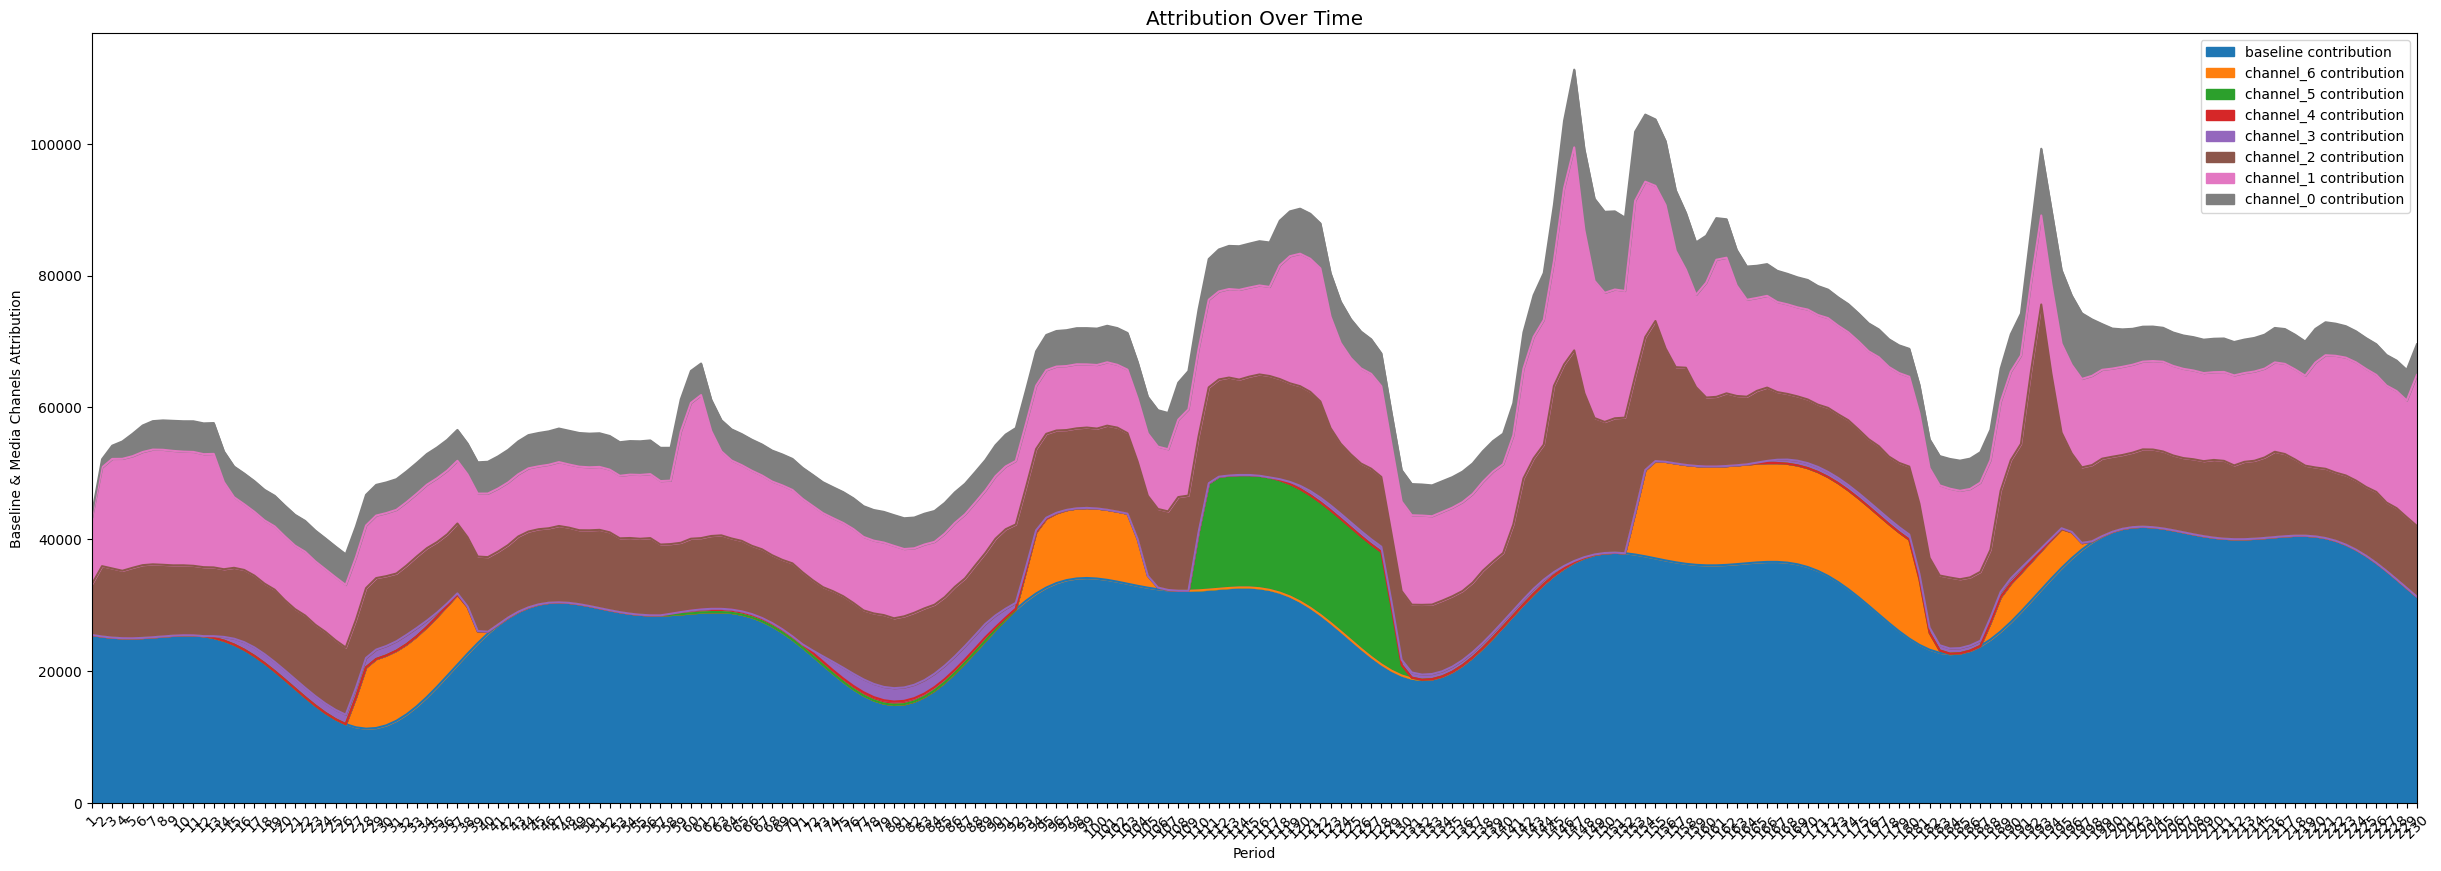

In [ ]:
custom_plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10))

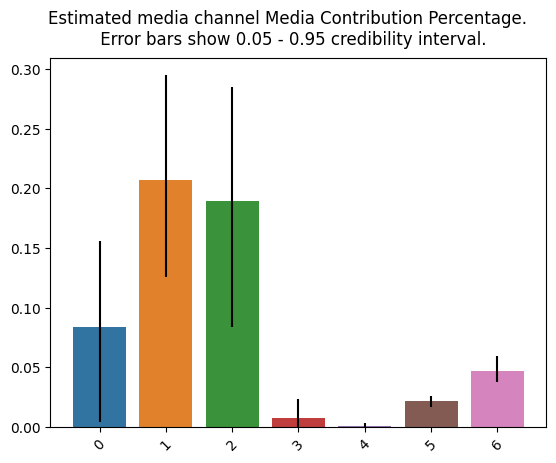

In [ ]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage")

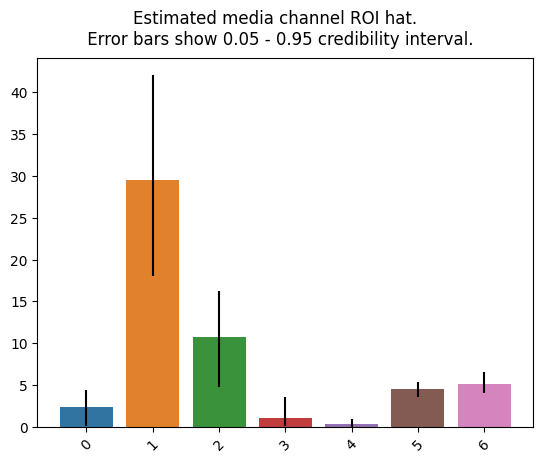

In [ ]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat")

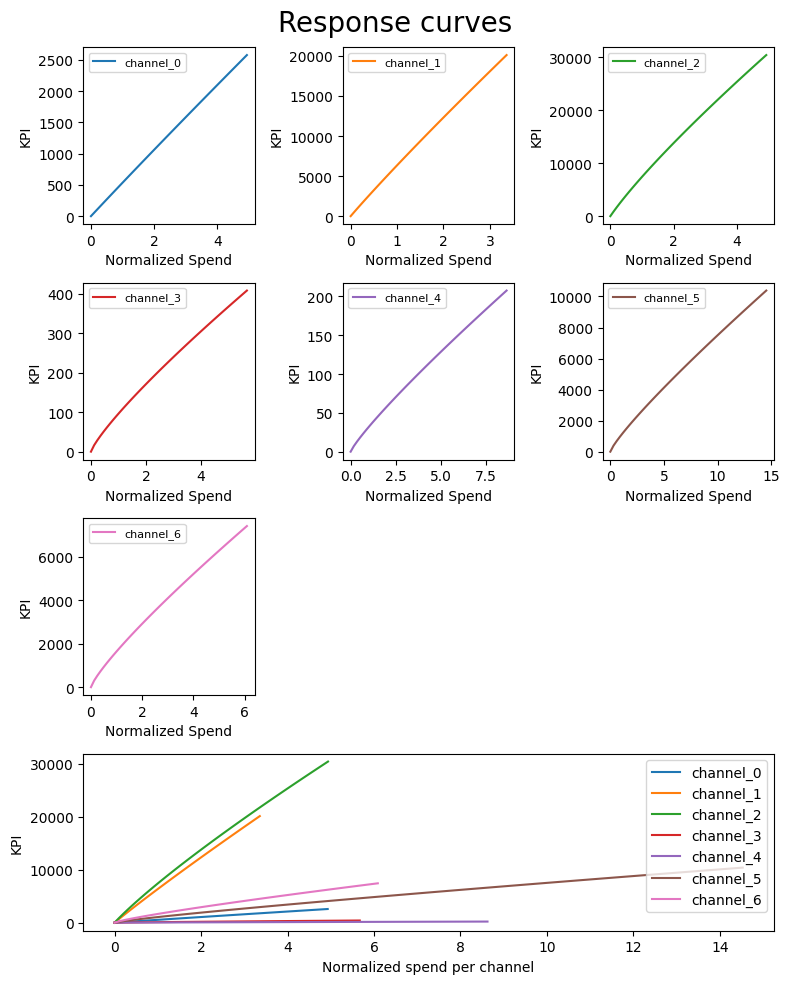

In [ ]:
plot.plot_response_curves(
    media_mix_model=mmm, target_scaler=target_scaler)

# Optimization

In [ ]:
prices = jnp.ones(mmm.n_media_channels)

In [ ]:
n_time_periods = 10
budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0)))* n_time_periods

In [ ]:
# Run optimization with the parameters of choice.
solution, kpi_without_optim, previous_budget_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -706681.8247549793
            Iterations: 23
            Function evaluations: 331
            Gradient evaluations: 22


In [ ]:
# Obtain the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

Array([19352.225 ,  4231.6924, 11376.33  ,  2539.1304,  1113.0433,
        2478.2612,  7095.6533], dtype=float32)

## We can plot the following:
1. Pre post optimization budget allocation comparison for each channel
2. Pre post optimization predicted target variable comparison

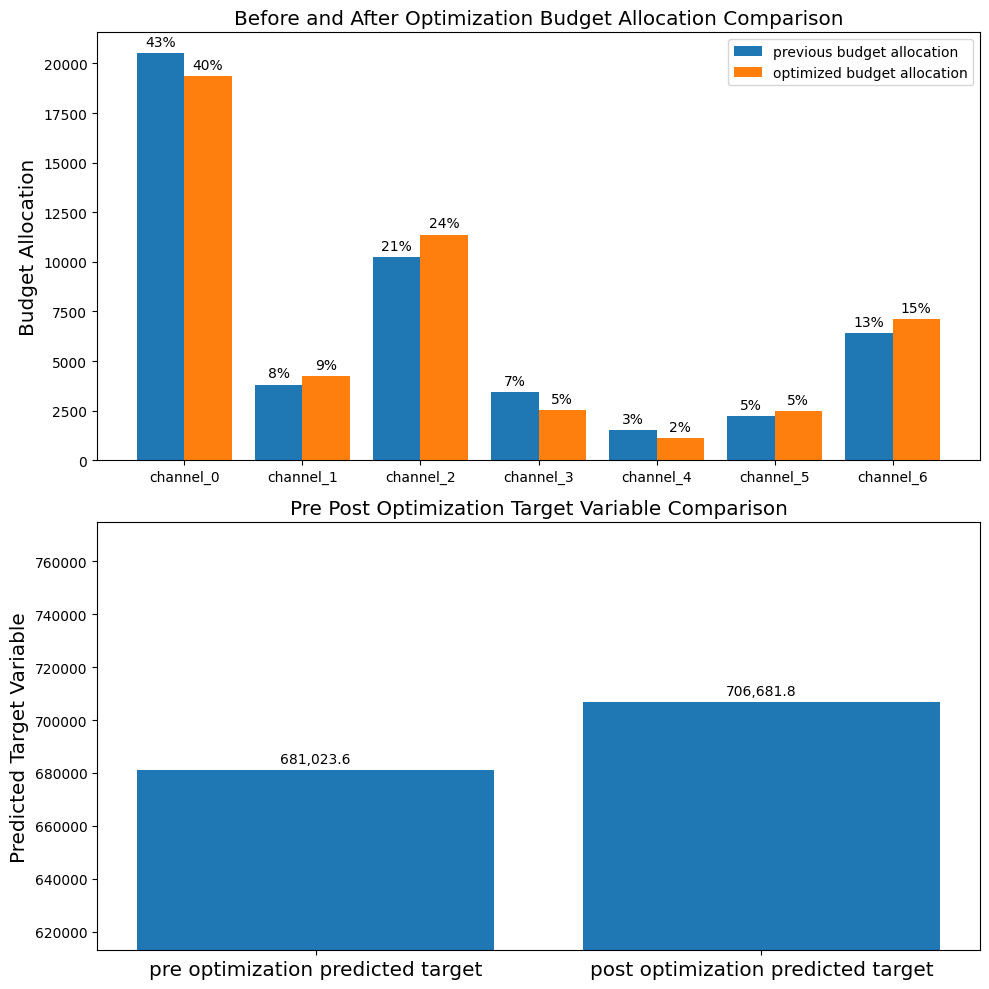

In [ ]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm,
                                                kpi_with_optim=solution['fun'],
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation,
                                                previous_budget_allocation=previous_budget_allocation,
                                                figure_size=(10,10))